# Notebook 02 — Statistical Baseline (Linear Regression)

This notebook trains a transparent regression model using simple, physically
meaningful features:

- Lagged GHI (t-1, t-2, t-24)
- Hour-of-day encoding (sin/cos)
- Optional temperature.

A time-based split is used (no shuffling) because random splits leak future
information and inflate performance unrealistically for forecasting problems.

## 1) Load data and UTC

In [5]:
import pandas as pd
import numpy as np 

df = pd.read_csv("../data/Dataset_phase_1_clean.csv")
df['time'] = pd.to_datetime(df['time'], utc=True)
df = df.sort_values('time')
df.head()

,time,ghi_wh_m2,temp_c
0,2021-01-01 00:00:00+00:00,0.0,23.35
1,2021-01-01 01:00:00+00:00,0.0,22.70
2,2021-01-01 02:00:00+00:00,0.0,22.03
3,2021-01-01 03:00:00+00:00,0.0,21.40
4,2021-01-01 04:00:00+00:00,0.0,20.78


## 2) Feature definition (lags + sin/cos hour + temp)

In [6]:
# creating autoregressinve features (lags) 
df['lag_1'] = df['ghi_wh_m2'].shift(1)     # lag_1 and lag_2 captures immediate momentum. They the model what happened one and two hours ago
df['lag_2'] = df['ghi_wh_m2'].shift(2)
df['lag_24'] = df['ghi_wh_m2'].shift(24)   # lag_24 captures seasonality/diurnal cycles. It tells the model what the solar radiation was at this exact same time yesterday

# Cyclical time encoding 
df['hour'] = df['time'].dt.hour
df['hour_sin'] = np.sin(2 * np.pi * df['hour'] / 24)
df['hour_cos'] = np.cos(2 * np.pi * df['hour'] / 24)

# Defining the target (Look-Ahead)
df['y'] = df['ghi_wh_m2'].shift(-1)        # The -1 pulls the data from future to rpesent row

# Cleaning the 'Shifting Gap'
df_model = df.dropna(subset=['lag_1', 'lag_2', 'lag_24', 'y']).copy()
df_model.head()

,time,ghi_wh_m2,temp_c,lag_1,lag_2,lag_24,hour,hour_sin,hour_cos,y
24,2021-01-02 00:00:00+00:00,0.0,23.46,0.0,0.0,0.0,0,0.000000,1.000000,0.0
25,2021-01-02 01:00:00+00:00,0.0,22.73,0.0,0.0,0.0,1,0.258819,0.965926,0.0
26,2021-01-02 02:00:00+00:00,0.0,22.02,0.0,0.0,0.0,2,0.500000,0.866025,0.0
27,2021-01-02 03:00:00+00:00,0.0,21.39,0.0,0.0,0.0,3,0.707107,0.707107,0.0
28,2021-01-02 04:00:00+00:00,0.0,20.80,0.0,0.0,0.0,4,0.866025,0.500000,0.0


## 3) Train/test split (no shuffling)

In [7]:
train = df_model[df_model['time'] < '2025-01-01'].copy()
test = df_model[df_model['time'] >= '2025-01-01'].copy()

print('Train rows: ', len(train))
print('Test rows: ', len(test))

Train rows:  35040
Test rows:  7991


## 4) Model training (LinearRegression)

In [8]:
from sklearn.linear_model import LinearRegression

x_train = train[['lag_1', 'lag_2', 'lag_24', 'hour_sin', 'hour_cos', 'temp_c']].values
y_train = train['y'].values

x_test = test[['lag_1', 'lag_2', 'lag_24', 'hour_sin', 'hour_cos', 'temp_c']].values
y_test = test['y'].values

model = LinearRegression()    # Initialization phase: has the math structure but doesn't know the weights(m) for the features like 'lag_1' etc, it allocate memory for coeff that will calculated in the next step
model.fit(x_train, y_train)   # Training phase  ("Fitting"): It calculates a specific weight (coefficient) for every feature you created (like lag_1 and hour_cos) to minimize the difference between its predictions and the real values.

y_pred = model.predict(x_test)

## 5) Evaluation (same metrics)

In [9]:
from sklearn.metrics import mean_absolute_error, mean_squared_error

rmse = np.sqrt(mean_squared_error(y_test, y_pred))
mae = mean_absolute_error(y_test, y_pred)

mask = y_test > 50
mape = np.mean(np.abs((y_test[mask] - y_pred[mask]) / y_test[mask])) * 100

print('Linear Regression - Test Year 2025')
print('RMSE: ', rmse)
print('MAE: ', mae)
print('MAPE (GHI>50 Wh/m2): ', mape)

Linear Regression - Test Year 2025
RMSE:  78.20880625319265
MAE:  55.90037340212352
MAPE (GHI>50 Wh/m2):  26.287604957057326


## 6) Compare vs persistence (side-by-side)
Create persistence predictions aligned to the same test rows:

In [10]:
# Persistence for same rows: predict y(t+1) using current GHI at time t
# In df_model, current time corresponds to features at time t, target is t+1
y_pred_persist = test["ghi_wh_m2"].values  # current hour value

rmse_p = np.sqrt(mean_squared_error(y_test, y_pred_persist))
mae_p = mean_absolute_error(y_test, y_pred_persist)

mask = y_test > 50
mape_p = np.mean(np.abs((y_test[mask] - y_pred_persist[mask]) / y_test[mask])) * 100

print("Persistence (aligned) — Test Year 2025")
print("RMSE:", rmse_p)
print("MAE :", mae_p)
print("MAPE (GHI>50 Wh/m²):", mape_p)

Persistence (aligned) — Test Year 2025
RMSE: 115.11471692798487
MAE : 74.71966211988487
MAPE (GHI>50 Wh/m²): 52.291658544020535


## 7) Bias vs variance intuition (operational view)

**Where linear regression improves:** it can learn systematic patterns (daily cycle,
seasonal context via lag-24, and temperature correlations) that persistence ignores.

**Where it fails:** rapid cloud-driven changes can break the linear assumption,
leading to underestimation of sharp ramps or delayed response.

This model is intentionally simple: the goal is to understand error behavior, not to
maximize leaderboard accuracy.

## 8) Results

## i) Model Comparison Summary (Test Year 2025)

| Metric | Persistence | Linear Regression | Improvement |
|--------|------------|------------------|-------------|
| RMSE | 115.11 | 78.21 | ↓ ~32% |
| MAE | 74.72 | 55.90 | ↓ ~25% |
| MAPE (>50) | 52.29% | 26.29% | ↓ ~50% |

## ii) Operational Interpretation
**RMSE ↓ 32%**
This is the most important result.

RMSE penalizes large errors heavily.
A 32% reduction means:

- Fewer severe hour-ahead misses
- Lower probability of emergency ramping
- Reduced reserve stress

For weak grids, this is significant.

**MAE ↓ 25%** 
This reflects average operator exposure.

In practical terms:
- On a typical hour, forecast deviation is ~19 Wh/m² smaller
- Less routine balancing action required
- Reduced regulation effort

This translates into lower operational friction.

**MAPE cut in half (52% → 26%)**
That is substantial.

Persistence struggles during: 
- cloud transitions
- dust events
- seasonal pattern shifts

Linear regression is learning:
- daily cycle (sin/cos encoding)
- lag-24 seasonal structure
- autoregressive memory
  
This explains the large MAPE reduction.

## iii) What This Means Strategically

This confirms something important: 
A transparent linear model already beats persistence meaningfully.

That is exactly what Phase 1 is meant to demonstrate:
- No deep learning
- No tuning
- No complexity
- Yet measurable operational improvement

## 9) Now Ask the Right Question: Where does linear regression still fail?

To understand grid relevance deeply, we look at the scatter plot and grid impact plot below:

### i) Scatter Plot with 45° Reference Line
(Actual vs Predicted + perfect forecast diagonal)

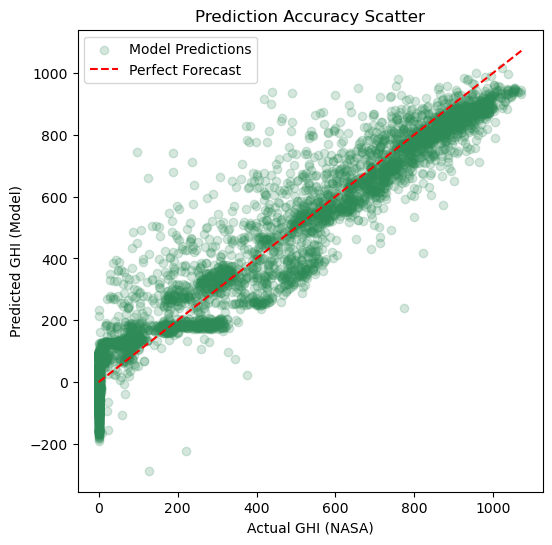

In [13]:
plt.figure(figsize=(6, 6))

# 1. Plot the relationship in one color
plt.scatter(y_test, y_pred, color="seagreen", alpha=0.2, label="Model Predictions")

# 2. Add a 'Perfect Forecast' reference line in a completely different color
limit = max(y_test.max(), y_pred.max())
plt.plot([0, limit], [0, limit], color="red", linestyle="--", label="Perfect Forecast")

# 3. Final touches
plt.xlabel("Actual GHI (NASA)")
plt.ylabel("Predicted GHI (Model)")
plt.title("Prediction Accuracy Scatter")
plt.legend()
plt.show()


It demonstrates clearly that
- The points align well in mid-range (300-800 Wh/m²) → good average fit.
- At high irradiance (>900 Wh/m²), predictions fall below the diagonal line → a systematic underestimation of peaks.
- At very low values, dispersion increases → instability near transitions.

For a clear interpretation (grid framing), this is not random error, but shows that;
- the linear model compresses extremes
- it smooths high irradiance values.
- it cannot capture nonlinear peak amplification 

In grid terms, midday PV peaks are consistently under-forecasted, that means upward reserve must repeatedly compensate. This is structural bias, not noise.

### ii) Grid Impact Plot (Forecast vs Actual + Surplus/Deficit Panel)
This plot best shows **dynamic ramp failure and operational consequences**.

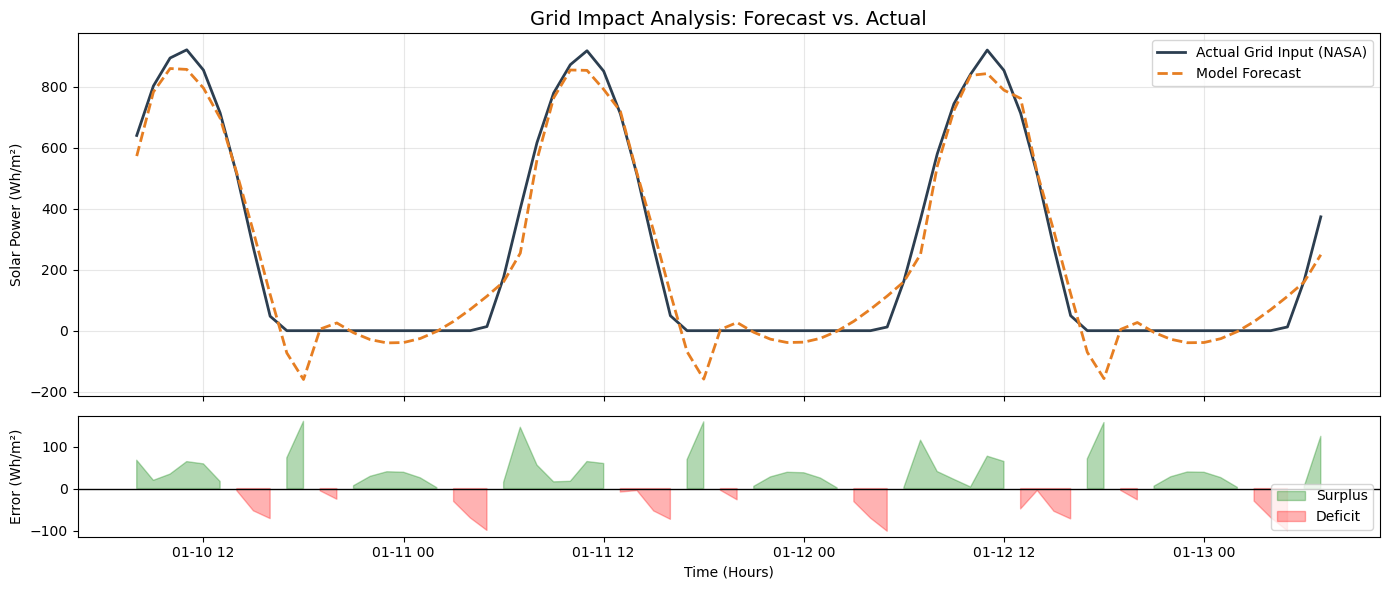

In [14]:
import matplotlib.pyplot as plt

# 1. Create a figure with two subplots (Top: Forecast, Bottom: Error)
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(14, 6), sharex=True, 
                               gridspec_kw={'height_ratios': [3, 1]})

# 2. TOP PLOT: The Power Balance
# We look at a 48-hour window (2 days) to see the day/night cycle clearly
window = slice(200, 272) 

ax1.plot(df_model.iloc[window]['time'], y_test[window], 
         label="Actual Grid Input (NASA)", color="#2c3e50", linewidth=2)
ax1.plot(df_model.iloc[window]['time'], y_pred[window], 
         label="Model Forecast", color="#e67e22", linestyle="--", linewidth=2)

ax1.set_ylabel("Solar Power (Wh/m²)")
ax1.set_title("Grid Impact Analysis: Forecast vs. Actual", fontsize=14)
ax1.legend(loc="upper right")
ax1.grid(alpha=0.3)

# 3. BOTTOM PLOT: The 'Grid Stress' (Residuals)
# This calculates the instantaneous error the grid must absorb
error = y_test - y_pred

ax2.fill_between(df_model.iloc[window]['time'], error[window], 0, 
                 where=(error[window] >= 0), color='green', alpha=0.3, label="Surplus")
ax2.fill_between(df_model.iloc[window]['time'], error[window], 0, 
                 where=(error[window] < 0), color='red', alpha=0.3, label="Deficit")

ax2.set_ylabel("Error (Wh/m²)")
ax2.set_xlabel("Time (Hours)")
ax2.axhline(0, color='black', lw=1) # Zero-error baseline
ax2.legend(loc="lower right")

plt.tight_layout()
plt.show()


It demonstrates that;
- epeated red deficit blocks at midday → peak underestimation.
- Alternating green/red near sunrise and sunset → ramp lag.
- Negative predictions at night → model instability.
- Asymmetry between surplus and deficit → risk imbalance.

For a clearer interpretation (grid framing), this plot translate statistical error into operational stress:
- Deficits → upward reserve activation risk.
- Surpluses → curtailment/downward regulation risk.
- Rapid sign changes during ramps → regulation burden.

This directly shows that the model is low-variance but biased and slow to respond during rapid transitions.

## Where Linear Regression Still Fails

### a. Structural Bias at High Irradiance

The scatter plot (Actual vs Predicted) shows systematic underestimation at high irradiance levels. While mid-range values are predicted accurately,
extreme peaks are compressed.

**Operational implication**:
Repeated under-forecasting of midday solar peaks increases the probability of upward reserve activation and reserve stress.

### b. Ramp Misalignment and Dynamic Lag

The grid-impact time-series plot reveals alternating surplus and deficit during sunrise and sunset transitions. This indicates temporal lag in
capturing rapid irradiance ramps.

**Operational implication**:
During sharp ramps, the model responds too slowly, increasing balancing requirements and regulation burden in weak grids.

These behaviors reflect a low-variance but biased linear model structure.